# Breast cancer detection with XGBoost and IBM Watson Machine Learning

This notebook contains steps and code to get data from the IBM Data Science Experience Community, create a predictive model, and start scoring new data. This notebook introduces commands for getting data and for basic data cleaning and exploration, model training, model persistance to Watson Machine Learning repository, model deployment, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.5, XGBoost and scikit-learn 0.17.

You will use a publicly available data set, Breast Cancer Wisconsin (Diagnostic) Data Set to train XGBoost Model, which is short for “Extreme Gradient Boosting”, to classify breast cancer tumors (as benign or malignant) from 569 diagnostic images based on measurements such as radius, texture, perimeter and area.

## Learning goals

The learning goals of this notebook are:

-  Load a CSV file into Pandas DataFrame.
-  Explore data.
-  Prepare data for training and evaluation.
-  Create an XGBoost machine learning model.
-  Train and evaluate a model.
-  Use cross-validation to optimize model's hyperparameters.
-  Persist a model in Watson Machine Learning repository.
-  Deploy a model for online scoring using Wastson Machine Learning API.
-  Score sample scoring data using the Watson Machine Learning API.
-  Explore and visualize prediction result using the plotly package.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Load and explore data](#load)
3.	[Create XGBoost model](#model)
4.	[Persist model](#persistence)
5.	[Deploy and score in a Cloud](#scoring)
6.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance (a free plan is offered). 
-  Upload **Breast Cancer Wisconsin (Diagnostic) Data Set** data as a data asset in IBM Data Science Experience.
-  Make sure that you are using a Spark 2.0 kernel.

### Getting Breast Cancer Wisconsin (Diagnostic) Data Set  

The Breast Cancer Wisconsin (Diagnostic) Data Set is a freely available data set on the Data Science Experience home page.

1.  Go to the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://apsportal.ibm.com/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=941eec501eadcdceb5abd25cf7c029d5) data card on the Data Science Experience **Community** page and open the card by double-clicking it.
2.  Click the link icon.
4.  Select the link, copy it by pressing Ctrl+C, and then, click **Close**.
5.  In the following cell, replace the **link_to_data** variable value with the link.

<a id="load"></a>
## 2. Load and explore data

In this section you will load the data as Pandas DataFrame and perform a basic exploration.

Load the data to the Pandas DataFrame by using *wget* to upload the data to gpfs and then *read* method. 

**Example**: First, you need to install required packages. You can do it by running the following code. Run it only one time.<BR><BR>
!pip install wget --user <BR>

In [1]:
import wget

link_to_data = 'https://apsportal.ibm.com/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=941eec501eadcdceb5abd25cf7c029d5'
WisconsinDataSet = wget.download(link_to_data)

print(WisconsinDataSet)

BreastCancerWisconsinDataSet (2).csv


The csv file **BreastCancerWisconsinDataSet.csv** is availble on gpfs now. Load the file to Pandas DataFrame using code below.

In [2]:
import pandas as pd

WisconsinDataSet = "BreastCancerWisconsinDataSet.csv"
df_data = pd.read_csv(WisconsinDataSet)
df_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


We can see how many records and features we have in our data set.

In [24]:
df_data.shape

(569, 32)

We can generate descriptive statistics of our dataset, excluding NaN values.

In [25]:
df_data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


<a id="model"></a>
## 3. Create XGBoost model

In recent years, ensemble learning models took the lead and became popular among machine learning practitioners.

Ensemble learning model employs multiple machine learning algorithms to overcome the potential weaknesses of a single model. For example, if you are going to pick a destination for your next vacation, you probably ask your family and friends, read reviews and blog posts. Based on all the information you have gathered, you make your final decision.

This phenomenon is referred as the Wisdom of Crowds (WOC) in social sciences and it states that averaging the answers (prediction or probability) of a group will often result better than the answer of one of its members. The idea is that the collective knowledge of diverse and independent individuals will exceed the knowledge of any one of those individuals, helping to eliminate the noise.

XGBoost is an open source library for ensemble based algorithms.

XGBoost classifier makes its predictions based on the majority vote from collection of models which are a set of classification trees. It uses the combination of weak learners to create single strong learner. It’s a sequential training process, new learners focus on the misclassified examples of previous learners.

In this section you will learn how to train and test a XGBoost model.

### 3.1: Prepare data

After looking at descriptive statistics, we can prepare our dataset for model building. We will use "diagnosis" columns as our target variable.

In [46]:
y = df_data['diagnosis'].map(lambda d: 1 if d == 'M' else 0)
X = df_data.drop(['diagnosis', 'id'], axis=1)

We split the dataset into: train and test datasets.

In [47]:
from sklearn.cross_validation import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [48]:
print("Number of training records: " + str(X_train.size))
print("Number of testing records : " + str(X_test.size))

Number of training records: 11070
Number of testing records : 6000


As you can see our data has been successfully split into two datasets:
- The train data set, which is the largest group, is used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 3.2: Create XGBoost model

We start with importing necessary libraries.

In [49]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

In below cell, we create our pipeline which contains XGBoost classifier.

In [50]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])

We can see the default parameters of the stages in our pipeline

In [51]:
pipeline

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

Once we have our pipeline with XGBoost classifier is set up, we can train it by invoking fit method.

In [53]:
pipeline.fit(X_train.values, y_train.values)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

We plot the feature importance based on fitted trees which allows us to see the features that were useful to construct boosted trees.

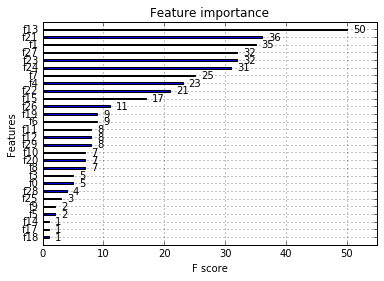

In [54]:
xgboost.plot_importance(pipeline.steps[1][1])

We can now make predictions on test data and evaluate the model

In [55]:
y_pred = pipeline.predict(X_test.values)

In [56]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.50%


We can tune our model now to achieve better accuracy by using grid search and cross validation.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape algorithm’s desired behavior. Let’s have a look at the most important ones,
- learning_rate (default=0.1): Boosting learning rate (xgb’s “eta”).
- n_estimators (default=100): Number of boosted trees to fit.
- max_depth (default=3): Maximum tree depth for base learners.
- objective (default='binary:logistic'): Specify the learning task and the corresponding learning objective or a custom objective function to be used.

In below cell, we create our XGBoost pipeline and setup parameter space.

In [89]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
parameters = {'classifier__learning_rate': [0.01, 0.03, 0.05], 'classifier__n_estimators': [10, 50, 250]}

We can search for the best parameters over specified parameters above with GridSearchCV. You can use estimator.get_params().keys() to see the available hyperparameters for search.

In [90]:
from sklearn.grid_search import GridSearchCV

clf = GridSearchCV(pipeline, parameters)

In [91]:
clf.fit(X_train.values, y_train.values)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classifier__learning_rate': [0.01, 0.03, 0.05], 'classifier__n_estimators': [10, 50, 250]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

We can see the performance result of all parameter combinations including the best parameter combination based on model performance from grid search scores

In [92]:
clf.grid_scores_

[mean: 0.92141, std: 0.01671, params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 10},
 mean: 0.93767, std: 0.01382, params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50},
 mean: 0.93225, std: 0.01382, params: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 250},
 mean: 0.92141, std: 0.01671, params: {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 10},
 mean: 0.92954, std: 0.01014, params: {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 50},
 mean: 0.94851, std: 0.01671, params: {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 250},
 mean: 0.92683, std: 0.01150, params: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 10},
 mean: 0.93225, std: 0.01382, params: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 50},
 mean: 0.95122, std: 0.01991, params: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 250}]

Best score and parameter set

In [96]:
print("Best score: %s" % (clf.best_score_))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 0.951219512195
Best parameter set: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 250}


We can see the accuracy of best parameter combination on test set.

In [98]:
y_pred = clf.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.00%


In [95]:
y_pred = clf.predict([X_test.values[55]])
print(y_pred)

[0]


Let's see how we can save our XGBoost pipeline using Watson Machine Learning instance and deploy it for online scoring.

<a id="persistence"></a>
## 4. Persist model

In this section you will learn how to store your XGBoost model in Watson Machine Learning repository by using python client libraries.

First, you must import client libraries.

**Note**: Apache® Spark 2.0 or higher is required.

In [14]:
from repository.mlrepository import MetaNames
from repository.mlrepository import MetaProps
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

Authenticate to Watson Machine Learning service on Bluemix.

**Action**: Put authentication information from your instance of Watson Machine Learning service here.</div>

**Action**: Put authentication information from your instance of Watson Machine Learning service here.</div>

In [15]:
service_path = "https://ibm-watson-ml.mybluemix.net"
username = "***"
password = "***"
instance_id = "***"

**Tip**: service_path, user and password can be found on **Service Credentials** tab of service instance created in Bluemix. If you cannot see **instance_id** field in **Serice Credentials** generate new credentials by pressing **New credential (+)** button. 

In [16]:
ml_repository_client = MLRepositoryClient(service_path)
ml_repository_client.authorize(username, password)

### 4.1: Save a XGBoost model in the ML Repository

In this subsection you will learn how to save model artifact to your Watson Machine Learning instance.

Create an artifact and save to ML Repository

In this subsection you will learn how to save model artifact to your Watson Machine Learning instance.

Create an artifact and save to ML Repository

In [38]:
# Check if props is mandatory
props1 = MetaProps({MetaNames.AUTHOR_NAME:"Umit", MetaNames.AUTHOR_EMAIL:"umit.cakmak@pl.ibm.com"})

model_artifact = MLRepositoryArtifact(pipeline, name='Tumor_Type_Detection_v1_pipe', meta_props=props1)

saved_model = ml_repository_client.models.save(model_artifact)

Get saved model metadata from Watson Machine Learning.

In [39]:
dict_meta = saved_model.meta.get()
pprint.pprint(dict_meta)

{'authorEmail': 'umit.cakmak@pl.ibm.com',
 'authorName': 'Umit',
 'creationTime': datetime.datetime(2017, 9, 5, 14, 51, 47, 839000, tzinfo=tzutc()),
 'lastUpdated': datetime.datetime(2017, 9, 5, 14, 51, 47, 917000, tzinfo=tzutc()),
 'modelType': 'scikit-model-0.17',
 'modelVersionHref': 'https://ibm-watson-ml.mybluemix.net/v2/artifacts/models/44a610af-d244-4da4-acdf-b6ecd8a54ec1/versions/3e097c48-36ba-481b-b0da-ee60d3d2f6a4',
 'pipelineVersionHref': None,
 'runtime': 'python-2.7',
 'trainingDataRef': {},
 'version': '3e097c48-36ba-481b-b0da-ee60d3d2f6a4'}


# 5. Deploy and score in a Cloud

In this section you will learn how to create online scoring and to score a new data record by using the Watson Machine Learning REST API. 
For more information about REST APIs, see the [Swagger Documentation](http://watson-ml-api.mybluemix.net/).


To work with the Watson Machine Leraning REST API you must generate an access token. To do that you can use the following sample code:

In [30]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{}:{}'.format(username, password))
url = '{}/v3/identity/token'.format(service_path)
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

### 5.1: Create online scoring endpoint

Now you can create an online scoring endpoint.

Get published_models url from instance details

In [31]:
#endpoint_instance = service_path + "/v3/wml_instances/" + instance_id
endpoint_instance = service_path + "/v3/wml_instances/" + instance_id
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
print(response_get_instance.text)

<Response [200]>
{"metadata":{"guid":"360c510b-012c-4793-ae3f-063410081c3e","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e","created_at":"2017-08-04T09:15:48.344Z","modified_at":"2017-09-05T14:38:41.487Z"},"entity":{"source":"Bluemix","published_models":{"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models"},"usage":{"expiration_date":"2017-10-01T00:00:00.000Z","computation_time":{"current":1},"model_count":{"limit":1000,"current":3},"prediction_count":{"current":3},"deployment_count":{"limit":1000,"current":5}},"plan_id":"0f2a3c2c-456b-40f3-9b19-726d2740b11c","status":"Active","organization_guid":"b0e61605-a82e-4f03-9e9f-2767973c084d","region":"us-south","account":{"id":"f52968f3dbbe7b0b53e15743d45e5e90","name":"Umit Cakmak's Account","type":"TRIAL"},"owner":{"ibm_id":"31000292EV","email":"umit.cakmak@pl.ibm.com","user_id":"43e0ee0e-6bfb-48fc-bcd8-d61e40d19253","country_code"

In [32]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')
print(endpoint_published_models)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models


Execute the following sample code that uses the published_models endpoint to get deployments url.

Get the list of published models

In [33]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

response_get = requests.get(endpoint_published_models, headers=header)
print(response_get)
print(response_get.text)

<Response [200]>
{"count":2,"resources":[{"metadata":{"guid":"03464067-1b50-41e4-887c-b2a68774a3c0","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/03464067-1b50-41e4-887c-b2a68774a3c0","created_at":"2017-09-05T14:29:04.642Z","modified_at":"2017-09-05T14:31:27.605Z"},"entity":{"runtime_environment":"python-2.7","author":{"name":"Krishna","email":"krishna@in.ibm.com"},"name":"Tumor_Type_Detection_v1","latest_version":{"url":"https://ibm-watson-ml.mybluemix.net/v2/artifacts/models/03464067-1b50-41e4-887c-b2a68774a3c0/versions/4f04bee2-33b9-4877-9c38-671942098c75","guid":"4f04bee2-33b9-4877-9c38-671942098c75","created_at":"2017-09-05T14:29:04.762Z"},"model_type":"scikit-model-0.17","deployments":{"count":1,"url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/03464067-1b50-41e4-887c-b2a68774a3c0/deployments"},"deployed_version":{"url":"https://ibm-watson-ml.mybluem

Get published model deployment url

In [34]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print(endpoint_deployments)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/f04b3fc4-d4b0-4da5-860c-396b4a8ba222/deployments


#### 5.1.2 Deploy Model

Create online deployment for published model

In [35]:
payload_online = {"name": "skl_xgb_cancer1_pipe", "description": "skl_xgb_Cancer", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print(response_online)
print(response_online.text)

<Response [201]>
{"metadata":{"guid":"076cbec1-fe05-4076-8fbb-ba5654f879c8","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/f04b3fc4-d4b0-4da5-860c-396b4a8ba222/deployments/076cbec1-fe05-4076-8fbb-ba5654f879c8","created_at":"2017-09-05T14:39:33.261Z","modified_at":"2017-09-05T14:39:34.212Z"},"entity":{"runtime_environment":"python-2.7","name":"skl_xgb_cancer1_pipe","scoring_url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/f04b3fc4-d4b0-4da5-860c-396b4a8ba222/deployments/076cbec1-fe05-4076-8fbb-ba5654f879c8/online","description":"skl_xgb_Cancer","published_model":{"author":{"name":"Krishna","email":"krishna@in.ibm.com"},"name":"Tumor_Type_Detection_v1_pipe","url":"https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/f04b3fc4-d4b0-4da5-860c-396b4a8ba222","guid":"f04b3fc4-d4b0-4da5-860c-396b4a8ba222","create

In [36]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/360c510b-012c-4793-ae3f-063410081c3e/published_models/f04b3fc4-d4b0-4da5-860c-396b4a8ba222/deployments/076cbec1-fe05-4076-8fbb-ba5654f879c8/online


### 5. 3 Perform Prediction

Now, you can send (POST) new scoring records (new data) for which you would like to get predictions. To do that, execute the following sample code:

In [37]:
payload_scoring = {
   "values": [0.16, 0.20, 0.010, 0.081, 11.69, 13.19, 14.78, 848.8, 19.48, 627.7, 43.75, 1.23, 3.27, 0.44, 6697.0, 208.3, 324.8, 139.2, 153.6, 2789.0, 0.2, 0.30, 0.013, 0.001, 15.90, 29.47, 35.97, 15.83, 31.03, 0.08],            
}

response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)
pprint.pprint(response_scoring.text)

u'{\n  "fields": ["prediction"],\n  "values": [[0]]\n}'


As we can see, given patient record is classified as benign.

<a id="summary"></a>
## 6. Summary and next steps     

You successfully completed this notebook! You learned how to use XGBoost machine learning as well as Watson Machine Learning for model creation and deployment. Check out our _[Online Documentation](https://console.ng.bluemix.net/docs/services/PredictiveModeling/pm_service_api_spark.html)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

Umit Mert Cakmak is Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable insights.

Copyright © 2017 IBM. This notebook and its source code are released under the terms of the MIT License.